$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Results and Summary
<a id=Results_Summary></a>
In this part, We will comare our bests modles on different samples.
Legitimate sources, which are very common for use today. For example, opening files or sockets

In [1]:
import os
import re
import sys
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import isadetect.helpers as isa_api 
import src.arch_v2_classifier as arch_api
import src.hyperparams as hp
from src.binary_dataset import FeatureDataset,DatasetToTuple,RawBinaryDataset,BinariesDataset, ClassifiedDataset
import src.arch_trainer as training

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Preprocessing 
We recommend to download this [dataset](https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz) before you run this block. 
After the dataset has been downloaded, place it on: '.pytorch-datasets' folder which should be located in in your home folder

In [4]:
import pathlib
import tarfile
import urllib
import shutil
DOWNLOAD_URL = 'https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_dataset(out_path=DATA_DIR, url=DOWNLOAD_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    tar_out_filename = os.path.join(out_path, os.path.basename(url))
    out_filename = tar_out_filename[:tar_out_filename.find(".tar")]

    if os.path.isfile(out_filename) and not force:
        print(f'Dataset file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(tar_out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {tar_out_filename}.')

        tf = tarfile.open(tar_out_filename)
        tf.extractall(out_path)
        print(f"All dataset extracte\nYou can start working!.")
    return out_filename

DATASET_FILE = "./dataset/binary_raw.json"
if not os.path.isfile(DATASET_FILE):
    DATASET_FILE = download_dataset()
binary_dataset = RawBinaryDataset(DATASET_FILE)

In [5]:
N = len(binary_dataset)
batch_size = 32
print(f'features length: {N}')

features length: 115000


In [6]:
train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binary_dataset,(train_length,test_length))
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

Train: 80500 samples
Test: 34500 samples


In [7]:
x0,y0 = ds_train[0]
dataset_shape = (x0.shape if x0.dim() > 0 else 1),(y0.shape if y0.dim() > 0 else 1)
print(x0.size(),y0.size())
print('input size =', dataset_shape[0], "X",dataset_shape[1] )

torch.Size([1000]) torch.Size([])
input size = torch.Size([1000]) X 1


## Load best modles

Now that we have found the best architecture for the inital calssification, we are going to use it in order to classify the entire binaries. Basically the result of the calssification will be the most popular result among the 1KB chunks of data

First, lets load the dataset which contains the full binaries

In [9]:
BINARIES_DATASET_DIR = "./dataset/binaries"
binaries_dataset = BinariesDataset(BINARIES_DATASET_DIR, 2500)

Now we will load our best model final checkpoint

In [10]:
CHECKPOINTS_PATH = "./checkpoints/"
saved_state = torch.load(CHECKPOINTS_PATH + "rnn.pt", map_location=torch.device('cpu'))

rnn_hp = hp.rnn_hp()
model = arch_api.RNN(rnn_hp['i_s'],batch_size,num_classes,rnn_hp['l'],rnn_hp['h_f'])
model.load_state_dict(saved_state['model_state'])

<All keys matched successfully>

Now we create our dataloaders

In [11]:
N = len(binaries_dataset)
train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binaries_dataset,(train_length,test_length))
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

Here we will activate our model on every block of the dataset

In [ ]:
import json

rnn_hp = hp.rnn_hp()
model = arch_api.RNN(rnn_hp['i_s'],batch_size,num_classes,rnn_hp['l'],rnn_hp['h_f'])
model.load_state_dict(saved_state['model_state'])

ARCHITECTURES = ['alpha', 'amd64', 'arm64', 'armel', 'armhf', 'hppa', 'i386', 'ia64', 'm68k','mips', 'mips64el','mipsel', 'powerpc', 'powerpcspe', 'ppc64', 'ppc64el', 'riscv64', 's390', 's390x','sh4', 'sparc', 'sparc64', 'x32']
for i in range(len(ARCHITECTURES)):
    if(os.path.isfile("./json_datasets/" + ARCHITECTURES[i] + "_final_classification.json")):
        continue
    json_data = {}
    for sample_idx in range(2500):
        if (sample_idx % 100 == 0):
            print(ARCHITECTURES[i] + ":" + str(sample_idx))
        stats = [0] * num_classes
        label = int(binaries_dataset[sample_idx + i*2500][1].item())
        if ARCHITECTURES[label] not in json_data:
            json_data[ARCHITECTURES[label]] = []
        data = binaries_dataset[sample_idx + i*2500][0]
        data = torch.split(data,1000)
        
        results = {}
        for block in range(len(data) - 1):
                result = model(data[block].reshape([1,1000])).tolist()
                results[str(block)] = result
        json_data[ARCHITECTURES[label]].append(results)

    with open("./json_datasets/" + ARCHITECTURES[i] + "_final_classification.json","w") as fj:
        json.dump(json_data,fj)

## The Final Competition

Now we will use naive approach

In [40]:
import json

ARCHITECTURES = ['alpha', 'amd64', 'arm64', 'armel', 'armhf', 'hppa', 'i386', 'ia64', 'm68k','mips', 'mips64el','mipsel', 'powerpc', 'powerpcspe', 'ppc64', 'ppc64el', 'riscv64', 's390', 's390x','sh4', 'sparc', 'sparc64', 'x32']
ARCHS_TO_CLASSIFY = ['alpha', 'amd64', 'arm64', 'armel', 'armhf', 'hppa', 'i386', 'ia64', 'm68k','mips', 'mips64el','mipsel', 'powerpc', 'powerpcspe', 'ppc64', 'ppc64el', 's390', 's390x','sh4', 'sparc', 'sparc64']
total_classified = 0

classification_results = {}

for arch in ARCHS_TO_CLASSIFY:
    successfully_classfied = 0
    # print("Checking arch: " + arch)
    json_file = open("./json_datasets/" + arch + "_final_classification.json", 'rb')
    data = json.load(json_file)
    json_file.close()
    samples = data[arch]
    for idx in range(2500):
        stats = [0] * num_classes
        sample = samples[idx]
        
        for chunk_idx in range(len(sample)):
            result = sample[str(chunk_idx)]
            stats[np.argmax(result)] += 1
    
        if np.argmax(stats) == ARCHITECTURES.index(arch):
            successfully_classfied +=1
        
    print(arch + ": " + str(successfully_classfied) + " out of 2500 were classified correctly")
    total_classified += successfully_classfied
    classification_results[arch] = float(successfully_classfied) / 2500.0 * 100.0
    
print("In total " + str(total_classified) + " samples were classified correctly")
    

alpha: 2475 out of 2500 were classified correctly
amd64: 2063 out of 2500 were classified correctly
arm64: 2489 out of 2500 were classified correctly
armel: 2493 out of 2500 were classified correctly
armhf: 2461 out of 2500 were classified correctly
hppa: 2499 out of 2500 were classified correctly
i386: 2293 out of 2500 were classified correctly
ia64: 2490 out of 2500 were classified correctly
m68k: 2235 out of 2500 were classified correctly
mips: 429 out of 2500 were classified correctly
mips64el: 2476 out of 2500 were classified correctly
mipsel: 2462 out of 2500 were classified correctly
powerpc: 2323 out of 2500 were classified correctly
powerpcspe: 1892 out of 2500 were classified correctly
ppc64: 2487 out of 2500 were classified correctly
ppc64el: 2491 out of 2500 were classified correctly
s390: 2450 out of 2500 were classified correctly
s390x: 2476 out of 2500 were classified correctly
sh4: 2317 out of 2500 were classified correctly
sparc: 2496 out of 2500 were classified correc

In [41]:
classification_results


{'alpha': 99.0,
 'amd64': 82.52000000000001,
 'arm64': 99.56,
 'armel': 99.72,
 'armhf': 98.44000000000001,
 'hppa': 99.96000000000001,
 'i386': 91.72,
 'ia64': 99.6,
 'm68k': 89.4,
 'mips': 17.16,
 'mips64el': 99.03999999999999,
 'mipsel': 98.48,
 'powerpc': 92.92,
 'powerpcspe': 75.68,
 'ppc64': 99.48,
 'ppc64el': 99.64,
 's390': 98.0,
 's390x': 99.03999999999999,
 'sh4': 92.67999999999999,
 'sparc': 99.83999999999999,
 'sparc64': 38.36}

Here we will plot them

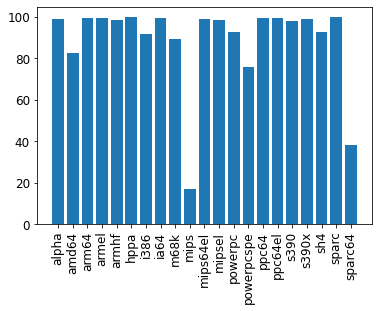

In [46]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.bar(range(len(classification_results)), list(classification_results.values()), align='center')
plt.xticks(range(len(classification_results)), list(classification_results.keys()), rotation='vertical')

plt.show()

Here we will use an MLP approach

In [9]:
import json
archs = ['alpha', 'amd64', 'arm64', 'armel', 'armhf', 'hppa', 'i386', 'ia64', 'm68k','mips', 'mips64el','mipsel', 'powerpc', 'powerpcspe', 'ppc64', 'ppc64el', 's390', 's390x','sh4', 'sparc', 'sparc64']

JSON_DATASETS_DIR = "./json_datasets/"
dataset = ClassifiedDataset(JSON_DATASETS_DIR, archs, 2500, 24)

N = len(dataset)
train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(dataset,(train_length,test_length))
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

In [47]:
mlp_hp = dict(hidden_size=[256], lr=0.1, momentum=0.95,dropout=0)

_mlp = arch_api.MLP(2*num_classes,num_classes,mlp_hp['hidden_size'],mlp_hp['dropout'])
optimizer = torch.optim.SGD(_mlp.parameters(), lr=mlp_hp["lr"],momentum=mlp_hp['momentum'])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_mlp, loss_fn, optimizer, device)
print(_mlp)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=24, bias=True)
    (3): Softmax(dim=1)
  )
)


Here we train our model

In [3]:
#fit_res.append({"legend":"Final_MLP","result":trainer.fit(dl_train,dl_test,num_epochs = 1,print_every=1,checkpoints="checkpoints/final_mlp")})